In [1]:
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

In [2]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories
, shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories
, shuffle = True, random_state = 42)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(train_dataset.target,bins=20, alpha=0.5, histtype='bar', ec='black',
        label=categories)

(array([ 584.,    0.,  591.,    0.,    0.,  590.,    0.,    0.,  578.,
           0.,    0.,  594.,    0.,    0.,  598.,    0.,    0.,  597.,
           0.,  600.]),
 array([ 0.  ,  0.35,  0.7 ,  1.05,  1.4 ,  1.75,  2.1 ,  2.45,  2.8 ,
         3.15,  3.5 ,  3.85,  4.2 ,  4.55,  4.9 ,  5.25,  5.6 ,  5.95,
         6.3 ,  6.65,  7.  ]),
 <a list of 20 Patch objects>)

In [4]:
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

In [6]:
vectorizer = CountVectorizer(min_df=3, 
                             analyzer=stem_rmv_punc, 
                             stop_words='english')

# fit_tranform train data
X_train_counts = vectorizer.fit_transform(train_dataset.data)
print("train count size ", X_train_counts.shape)


X_test_counts = vectorizer.transform(test_dataset.data)
print("test count size ", X_test_counts.shape)

# vectorizer.get_feature_names()

train count size  (4732, 16600)
test count size  (3150, 16600)


In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit_tranform train data
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#print(X_train_tfidf.shape)
#print('-' * 20)
#print(X_train_counts.toarray()[:10,:5])
#print('-' * 20)
#print(X_train_tfidf.toarray()[:10,:5])

# transform test data
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
#print(X_test_tfidf.shape)
#print('-' * 20)
#print(X_test_counts.toarray()[:10,:5])
#print('-' * 20)
#print(X_test_tfidf.toarray()[:10,:5])

In [25]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
print(X_train_reduced.shape)

(4732, 50)


## Question 5 Logistic Classifier

### Part 1: Logistic classifier without regularization

#### Classify the documents into two classes

##### _, idx = np.unique(train_dataset.target, return_index=True)
for i in range(len(idx)):
    j = np.sort(idx)[i]
    print(train_dataset.target_names[i],': target index = ', train_dataset.target[j])

#print(train_dataset.target[15:25])
#print(train_dataset.target_names[15:25])

In [8]:
train_dataset.bintarget = np.zeros_like(train_dataset.target)
test_dataset.bintarget = np.zeros_like(test_dataset.target)
for y in [6, 7, 4, 2]:
    train_dataset.bintarget[np.argwhere(train_dataset.target == y)] = 0
    test_dataset.bintarget[np.argwhere(test_dataset.target == y)] = 0
for y in [1, 3, 0, 5]:
    train_dataset.bintarget[np.argwhere(train_dataset.target == y)] = 1
    test_dataset.bintarget[np.argwhere(test_dataset.target == y)] = 1
class_names = ['Computer Technology', 'Recreational Activity']
#print(train_dataset.bintarget[:20])

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator, TransformerMixin
class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self

from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.pipeline import Pipeline

pipeline3 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    # ('toarr', SparseToDenseArray()),
    ('clf', LogisticRegression(C=10000)),
])




In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr)
#     return pipe

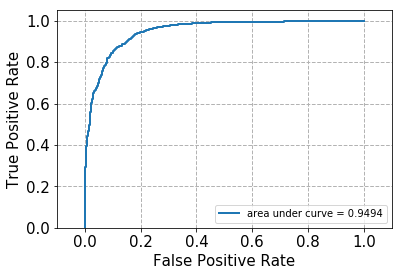

In [17]:
fit_predict_and_plot_roc(pipeline3, train_dataset.data, train_dataset.bintarget, test_dataset.data, test_dataset.bintarget)

#### Confusion Matrix

In [13]:
pred3 = pipeline3.predict(test_dataset.data)

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('accuracy:', accuracy_score(test_dataset.bintarget, pred3))
print('recall:', recall_score(test_dataset.bintarget, pred3))
print('precision:', precision_score(test_dataset.bintarget, pred3))
print('f1_score:', f1_score(test_dataset.bintarget, pred3))

accuracy: 0.823492063492
recall: 0.872924648787
precision: 0.792923433875
f1_score: 0.831003039514


Confusion matrix, without normalization
[[1227  357]
 [ 199 1367]]
Normalized confusion matrix
[[ 0.77  0.23]
 [ 0.13  0.87]]


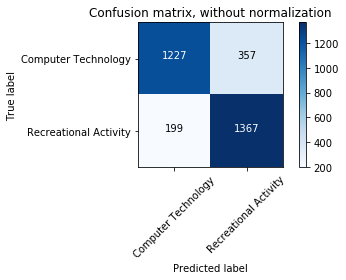

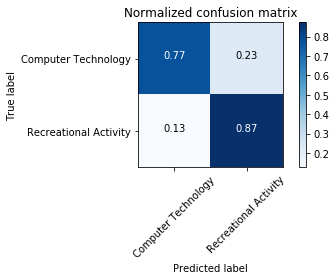

In [20]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_dataset.bintarget, pred3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Part 2:  Logistic classifier with regularization

In [37]:
from sklearn.model_selection import cross_val_score
# from sklearn import metrics
from sklearn.linear_model import LogisticRegression
    
gammas = [1e-3, 3.3e-3, 1e-2, 3.3e-2, 1e-1, 3.3e-1, 1, 3.3, 1e1, 3.3e1, 1e2, 3.3e2, 1e3]
best_score_l1 = 0
for gamma_l1 in gammas:
    clf_l1 = LogisticRegression(penalty='l1', C=gamma_l1)
    scores_l1 = cross_val_score(clf_l1, X_train_reduced, train_dataset.bintarget, cv=5, scoring='accuracy')
    if np.mean(scores) > best_score_l1:
        best_score_l1 = np.mean(scores_l1)
        best_gamma_l1 = gamma_l1
    print('gamma_l1 = ', gamma_l1, '; validation accuracy = ', scores_l1)
    
best_score_l2 = 0
for gamma_l2 in gammas:
    clf_l2 = LogisticRegression(penalty='l2', C=gamma_l2)
    scores_l2 = cross_val_score(clf_l2, X_train_reduced, train_dataset.bintarget, cv=5, scoring='accuracy')
    if np.mean(scores) > best_score_l2:
        best_score_l2 = np.mean(scores_l2)
        best_gamma_l2 = gamma_l2
    print('gamma_l2 = ', gamma_l2, '; validation accuracy = ', scores_l2)

gamma_l1 =  0.001 ; validation accuracy =  [ 0.5  0.5  0.5  0.5  0.5]
gamma_l1 =  0.0033 ; validation accuracy =  [ 0.5  0.5  0.5  0.5  0.5]
gamma_l1 =  0.01 ; validation accuracy =  [ 0.5  0.5  0.5  0.5  0.5]
gamma_l1 =  0.033 ; validation accuracy =  [ 0.74  0.74  0.76  0.77  0.74]
gamma_l1 =  0.1 ; validation accuracy =  [ 0.8   0.82  0.8   0.83  0.82]
gamma_l1 =  0.33 ; validation accuracy =  [ 0.86  0.86  0.84  0.86  0.85]
gamma_l1 =  1 ; validation accuracy =  [ 0.87  0.86  0.87  0.88  0.87]
gamma_l1 =  3.3 ; validation accuracy =  [ 0.88  0.87  0.88  0.88  0.88]
gamma_l1 =  10.0 ; validation accuracy =  [ 0.88  0.87  0.88  0.88  0.88]
gamma_l1 =  33.0 ; validation accuracy =  [ 0.88  0.87  0.88  0.88  0.88]
gamma_l1 =  100.0 ; validation accuracy =  [ 0.88  0.86  0.88  0.87  0.88]
gamma_l1 =  330.0 ; validation accuracy =  [ 0.88  0.86  0.88  0.88  0.88]
gamma_l1 =  1000.0 ; validation accuracy =  [ 0.88  0.86  0.88  0.88  0.88]
gamma_l2 =  0.001 ; validation accuracy =  [ 0.58 

In [39]:
print('best gamma_l1 = ', best_gamma_l1)
print('mean validation accuray L1 = ', best_score_l1)
print('best gamma_l2 = ', best_gamma_l2)
print('mean validation accuray L2 = ', best_score_l2)

best gamma_l1 =  3.3
mean validation accuray L1 =  0.877219204111
best gamma_l2 =  3.3
mean validation accuray L2 =  0.876585846692


In [41]:
pipeline_l1 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', LogisticRegression(penalty='l1', C=best_gamma_l1)),
])
pipeline_l2 = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', LogisticRegression(penalty='l2', C=best_gamma_l2)),
])

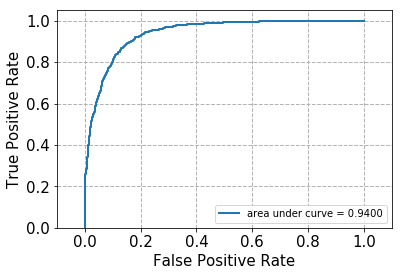

In [42]:
fit_predict_and_plot_roc(pipeline_l1, train_dataset.data, train_dataset.bintarget, test_dataset.data, test_dataset.bintarget)

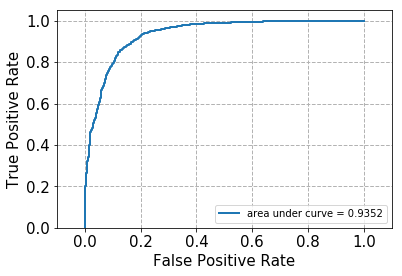

In [43]:
fit_predict_and_plot_roc(pipeline_l2, train_dataset.data, train_dataset.bintarget, test_dataset.data, test_dataset.bintarget)

In [47]:
pred_l1 = pipeline_l1.predict(test_dataset.data)
print('accuracy:', accuracy_score(test_dataset.bintarget, pred_l1))
print('recall:', recall_score(test_dataset.bintarget, pred_l1))
print('precision:', precision_score(test_dataset.bintarget, pred_l1))
print('f1_score:', f1_score(test_dataset.bintarget, pred_l1))

accuracy: 0.869206349206
recall: 0.889527458493
precision: 0.853553921569
f1_score: 0.871169480926


In [48]:
pred_l2 = pipeline_l2.predict(test_dataset.data)
print('accuracy:', accuracy_score(test_dataset.bintarget, pred_l2))
print('recall:', recall_score(test_dataset.bintarget, pred_l2))
print('precision:', precision_score(test_dataset.bintarget, pred_l2))
print('f1_score:', f1_score(test_dataset.bintarget, pred_l2))

accuracy: 0.864126984127
recall: 0.895913154534
precision: 0.841127098321
f1_score: 0.86765615337


Confusion matrix, without normalization
[[1345  239]
 [ 173 1393]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.11  0.89]]


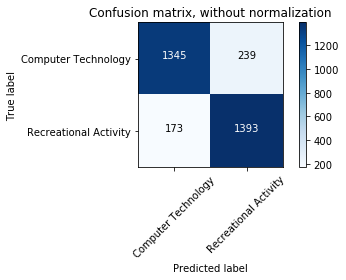

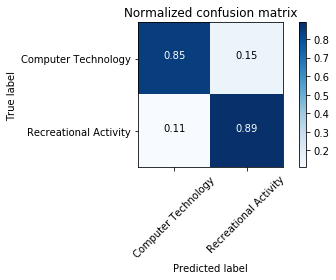

In [49]:
# Compute confusion matrix-L1
cnf_matrix_l1 = confusion_matrix(test_dataset.bintarget, pred_l1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_l1, classes=class_names,
                      title='Confusion matrix, without normalization-L1')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_l1, classes=class_names, normalize=True,
                      title='Normalized confusion matrix-L1')

plt.show()

Confusion matrix, without normalization
[[1345  239]
 [ 173 1393]]
Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.11  0.89]]


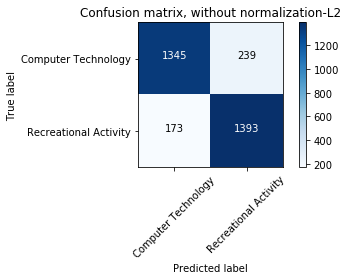

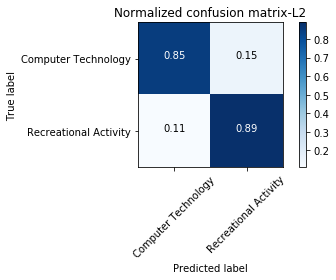

In [50]:
# Compute confusion matrix-L2
cnf_matrix_l2 = confusion_matrix(test_dataset.bintarget, pred_l2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_l1, classes=class_names,
                      title='Confusion matrix, without normalization-L2')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_l1, classes=class_names, normalize=True,
                      title='Normalized confusion matrix-L2')

plt.show()

### Compare w/o regularization, L1 , L2 regularization

$L1$ and $L2$ regularization can obtain similar accuracy and outperform the w/o regularization case. 
$L1$ sparsity; $L2$ shrinkage

### Compare linear logistic and linear SVM 